# Transfer Learning use case

On this notebook we will cover the fine tuning of a simple model on a custom dataset, taking a previously trained model. We will cover the next topics:
- dogs/cats/horses dataset
- Model architecture: 
    - VGG16
    - Dense layers
- Image generator from a directory
- Test on random images
### The dataset

The dataset is composed of 197 images of dogs, cats and horses. It is structured to be in label-related folders:

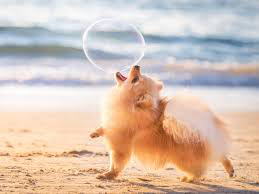

In [19]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
# tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

complete_path = os.path.join(os.path.dirname(os.getcwd()), 'complete')
datasets_path = os.path.join(os.path.dirname(os.getcwd()), 'datasets')

cats_dogs_horses_path = os.path.join(datasets_path, 'cats_dogs_horses')
dogs_path = os.path.join(cats_dogs_horses_path, 'dogs')
horses_path = os.path.join(cats_dogs_horses_path, 'horses')
cats_path = os.path.join(cats_dogs_horses_path, 'cats')

tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras.preprocessing import image
image.load_img(os.path.join(dogs_path,'images (8).jpg'))

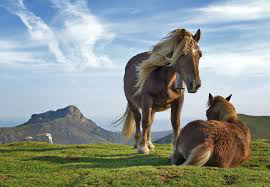

In [20]:
image.load_img(os.path.join(horses_path,'images (11).jpg'))

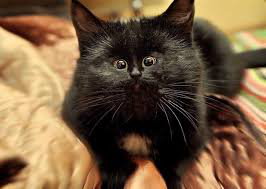

In [21]:
image.load_img(os.path.join(cats_path,'images (15).jpg'))

Please note the unbalance on the classes, which could be an issue if we were to train more seriously...

## Model Architecture
Build the model to use a pretrained vgg16 network without the last layer, pretrained on imagenet. Then:
- Add a global average pooling layer after the pre-trained structure
- Add a dense layer, with 512 units and relu activated
- The final layer will be another fully connected with the number of classes and softmax activated.


<font color=red> Hint: use the imported libraries</font>

In [22]:
import pandas as pd
import numpy as np
# import os
import keras

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet, VGG16

# base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last layer.
base_model=VGG16(weights='imagenet',include_top=False) #imports the vgg16 model and discards the last layer.
base_model.trainable=False 
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

<font color=red> Create the model and print the summary. What happens with the weights?</font>

In [23]:
from keras.models import Model

model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

<font color=red> Set the first 19 layers to non_trainable, and the rest to trainable. </font>

In [24]:
len(model.layers)

22

In [25]:
for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True

<font color=red> Create the generator and specify it will use the vgg preprocessing input function. No other data augmentation so far. Add the flow_from directory function to include where the data will be taken from. <br>Use target size of 224 square. </font>

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16

# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_mobilenet) #included in our dependencies
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_vgg16) #included in our dependencies

train_generator=train_datagen.flow_from_directory(cats_dogs_horses_path, # this is where you specify the path to the main data folder
                                                  target_size=(224,224),
                                                  # default parameters
                                                  color_mode='rgb',
                                                  batch_size=2,
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 197 images belonging to 3 classes.


<font color=red> Compile the model, using adam and categorical Xentropy. Include accuracy as a metric. <br> Train the model for 5 epochs. Remember to include the right step_size. Hint: use the generator .n and .batch_size properties </font>

In [27]:
from keras.optimizers import Adam
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=5)

Epoch 1/5
98/98 [==============================] - 80s 814ms/step - loss: 1.7081 - accuracy: 0.8410
Epoch 2/5
98/98 [==============================] - 81s 827ms/step - loss: 0.5362 - accuracy: 0.9538
Epoch 3/5
98/98 [==============================] - 80s 815ms/step - loss: 0.3726 - accuracy: 0.9744
Epoch 4/5
98/98 [==============================] - 79s 810ms/step - loss: 0.0384 - accuracy: 0.9949
Epoch 5/5
98/98 [==============================] - 82s 838ms/step - loss: 0.0912 - accuracy: 0.9847


<font color=red> Build a function to test the model on random images from internet. Predict the ones from the given directory <br> Hints: <br> - USe the previously loaded functions
<br> - Repeat the processing we did before. No, you are not repeating it. See why? </font>

cats


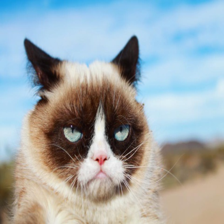

In [30]:
from numpy import expand_dims
import matplotlib.pyplot as plt

class_dict = {v:k for k, v in train_generator.class_indices.items()}

def predict_image(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_vgg16(data)
    preds = model.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    return img

chorra_tests_path = os.path.join(datasets_path, 'chorra_tests')
predict_image(os.path.join(chorra_tests_path,'gato.jpg'))

horses


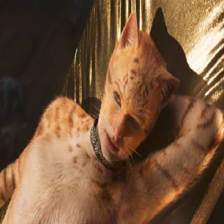

In [34]:
predict_image(os.path.join(chorra_tests_path,'aberracion.png'))

horses


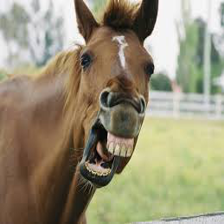

In [35]:
predict_image(os.path.join(chorra_tests_path,'horse_luis.jpeg'))

dogs


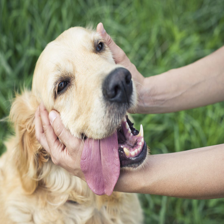

In [36]:
predict_image(os.path.join(chorra_tests_path,'dog.jpeg'))

dogs


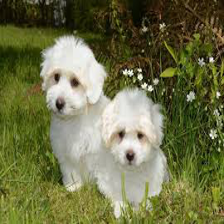

In [37]:
predict_image(os.path.join(dogs_path,'images (11).jpg'))

In [ ]:
import os
path  = dogs_path
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            predict_image(new_path)

dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
dogs
